# MongoDB II: Aggregation Pipelines

# Import Libraries

In [1]:
# To connect to a MongoDB instance
from pymongo import MongoClient
# For some types of data manipulation
import pandas as pd
# For nicer document printing
import pprint as pp
# For working with datetime objects
from datetime import datetime
# For timing operations
import time
# For exporting checkpoints
import subprocess
# For interactive plotting
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Establish a MongoDB Connection

In [2]:
client = MongoClient("mongodb://localhost:27017/")
print(client.list_database_names())

['admin', 'config', 'local']


# Drop <code>clickstream</code> if Exists (Optional)

In [8]:
# db_name = "clickstream"
# client.drop_database(db_name)
# print(client.list_database_names())

['admin', 'config', 'local']


# Import Data

In [9]:
HOST = "localhost"
PORT = "27017"
DBNAME = "clickstream"
IMPORT_FILE_FOLDER = "data"
BSON_FILE_NAME = "clicks"
JSON_FILE_NAME = "clicks.metadata"
bson_file = f"{IMPORT_FILE_FOLDER}\\{BSON_FILE_NAME}.bson"
json_file = f"{IMPORT_FILE_FOLDER}\\{JSON_FILE_NAME}.json"
collection_bson = BSON_FILE_NAME
collection_json = JSON_FILE_NAME

In [ ]:
!mongorestore --host {HOST}:{PORT} --db {DBNAME} --collection {collection_bson} --drop "{bson_file}"
!mongoimport --host {HOST}:{PORT} --db {DBNAME} --collection {collection_json} --drop --type json "{json_file}"

In [ ]:
# 2025-06-08T13:59:20.871-0600  finished restoring clickstream.clicks (6100000 documents, 0 failures)
# 2025-06-08T13:59:20.872-0600  no indexes to restore for collection clickstream.clicks
# 2025-06-08T13:59:20.873-0600  6100000 document(s) restored successfully. 0 document(s) failed to restore.
# 2025-06-08T13:59:21.819-0600  connected to: mongodb://localhost:27017/
# 2025-06-08T13:59:21.821-0600  dropping: clickstream.clicks.metadata
# 2025-06-08T13:59:21.853-0600  1 document(s) imported successfully. 0 document(s) failed to import.

In [12]:
db_name = "clickstream"
db = client[db_name]
collections = db.list_collection_names()
print(collections)

['clicks', 'clicks.metadata']


# Data Exploration

## Sample Record

In [13]:
collection = db['clicks']
collection.find_one()

{'_id': ObjectId('60df1029ad74d9467c91a932'),
 'webClientID': 'WI100000244987',
 'VisitDateTime': datetime.datetime(2018, 5, 25, 4, 51, 14, 179000),
 'ProductID': 'Pr100037',
 'Activity': 'click',
 'device': {'Browser': 'Firefox', 'OS': 'Windows'},
 'user': {'City': 'Colombo', 'Country': 'Sri Lanka'}}

## Count Documents

In [14]:
collection.count_documents({})

6100000

## Get Date Range

In [15]:
pipeline = [
    {
        "$group": {
            "_id": None,
            "minDate": {"$min": "$VisitDateTime"},
            "maxDate": {"$max": "$VisitDateTime"}
        }
    }
]

result = collection.aggregate(pipeline)
for doc in result:
    pp.pprint(doc)

{'_id': None,
 'maxDate': datetime.datetime(2018, 5, 27, 23, 59, 59, 576000),
 'minDate': datetime.datetime(2018, 5, 7, 0, 0, 1, 190000)}


## Count of Unique <code>webClientID</code> Values

In [16]:
pipeline = [
    { "$group": { "_id": "$webClientID" } },
    { "$count": "uniqueCount" }
]

result = list(collection.aggregate(pipeline))
num_unique = result[0]['uniqueCount'] if result else 0
print(f"Number of unique webClientID values: {num_unique}")

Number of unique webClientID values: 1091455


## Get Count of <code>webClientID</code> Values with a <code>userID</code>

In [19]:
result = collection.distinct(
    "webClientID",
    {"user.UserID": {"$exists": True, "$ne": None}}
)

len(result)

36791

## Number of Unique <code>user.UserID</code> Values

In [17]:
pipeline = [
    {"$match": {"user.UserID": {"$exists": True, "$ne": None}}},
    {"$group": {"_id": "$user.UserID"}},
    {"$count": "uniqueUserIDs"}
]

result = collection.aggregate(pipeline)
count = next(result, {"uniqueUserIDs": 0})["uniqueUserIDs"]
print(count)

34050


# Classify Device Type as Bot, Desktop, or Mobile

## Get Lists of Distinct <code>device.OS</code> and <code>device.Browser</code> Values

In [20]:
os_list = collection.distinct("device.OS")
print(", ".join(map(str, os_list)))

Android, BlackBerry OS, Chrome OS, Chromecast, Fedora, FreeBSD, Kindle, Linux, Mac OS X, NetBSD, OpenBSD, Other, Solaris, Tizen, Ubuntu, Windows, Windows Phone, iOS


In [21]:
os_list = collection.distinct("device.Browser")
print(", ".join(map(str, os_list)))

AdsBot-Google, AhrefsBot, Amazon Silk, Android, AppEngine-Google, Apple Mail, BingPreview, BlackBerry WebKit, Chrome, Chrome Mobile, Chrome Mobile WebView, Chrome Mobile iOS, Chromium, Coc Coc, Coveobot, Crosswalk, Dragon, DuckDuckBot, Edge, Edge Mobile, Electron, Epiphany, Facebook, FacebookBot, Firefox, Firefox Mobile, Firefox iOS, HbbTV, HeadlessChrome, HubSpot Crawler, IE, IE Mobile, Iceweasel, Iron, JobBot, Jooblebot, K-Meleon, Kindle, Konqueror, Magus Bot, Mail.ru Chromium Browser, Maxthon, Mobile Safari, Mobile Safari UI/WKWebView, MobileIron, NetFront, Netscape, Opera, Opera Coast, Opera Mini, Opera Mobile, Other, PagePeeker, Pale Moon, PetalBot, PhantomJS, Pinterest, Puffin, Python Requests, QQ Browser, QQ Browser Mobile, Radius Compliance Bot, Safari, Samsung Internet, SeaMonkey, Seekport Crawler, SiteScoreBot, Sleipnir, Sogou Explorer, Thunderbird, UC Browser, Vivaldi, WebKit Nightly, WordPress, Yandex Browser, YandexAccessibilityBot, YandexBot, YandexSearch, Yeti, YisouSpid

In [22]:
mobile_os = [
    'Android', 'iOS', 'Windows Phone', 'BlackBerry OS', 'Tizen', 'Kindle', 'Chromecast'
]
desktop_os = [
    'Windows', 'Mac OS X', 'Linux', 'Ubuntu', 'Fedora', 'FreeBSD', 
    'NetBSD', 'OpenBSD', 'Solaris', 'Chrome OS', 'Other'
]
bot_browsers = [
    'AdsBot-Google', 'AhrefsBot', 'BingPreview', 'DuckDuckBot', 'FacebookBot',
    'HubSpot Crawler', 'JobBot', 'Jooblebot', 'Magus Bot', 'PetalBot',
    'Radius Compliance Bot', 'Seekport Crawler', 'SiteScoreBot', 'YandexBot',
    'YandexAccessibilityBot', 'YandexSearch', 'Yeti', 'YisouSpider', 'moatbot',
    'net/bot', 'AppEngine-Google', 'PagePeeker', 'Pinterest', 'Facebook',
    'Python Requests', 'Coveobot', 'HeadlessChrome', 'PhantomJS', 'WordPress'
]

## Classify the Documents

In [ ]:
mobile_os = [x.lower() for x in mobile_os]
desktop_os = [x.lower() for x in desktop_os]
bot_browsers = [x.lower() for x in bot_browsers]

# report progress while updating
record_count = 0
progress_interval = 100000

# start a timer
start_time = time.time()

# loop through records in the collection
for record in collection.find({}, {'device.OS': 1, 'device.Browser': 1}):
    browser = record.get('device', {}).get('Browser', '').lower().strip()
    os = record.get('device', {}).get('OS', '').lower().strip()

    # determine device_type for record
    if browser in bot_browsers:
        device_type = 'bot'
    elif os in mobile_os:
        device_type = 'mobile'
    elif os in desktop_os:
        device_type = 'desktop'
    else:
        device_type = None
    
    # update the record's device_type
    result = collection.update_one(
        {"_id": record['_id']},
        {"$set": {
            "device_type": device_type
        }}
    )
    
    # increment count
    if result.modified_count > 0:
        record_count += 1

    # report progress
    if record_count % progress_interval == 0 and record_count > 0:
        print(f"Processed {record_count} records")

elapsed_time = time.time() - start_time
print(f"Completed: Updated device_type for {record_count} records in {elapsed_time:.0f} seconds")

In [ ]:
# Processed 100000 records
# Processed 200000 records
# ...
# Processed 6000000 records
# Processed 6100000 records
# Completed: Updated device_type for 6100000 records in 2638 seconds

## Alternative <code>bulk_write</code> Method

In [ ]:
# from pymongo import UpdateOne

# mobile_os = [x.lower() for x in mobile_os]
# desktop_os = [x.lower() for x in desktop_os]
# bot_browsers = [x.lower() for x in bot_browsers]

# batch_size = 500000
# operations = []
# records_processed = 0
# records_written = 0

# # start a timer
# start_time = time.time()

# for record in collection.find({}, {'device.OS': 1, 'device.Browser': 1}):
#     browser = record.get('device', {}).get('Browser', '').lower().strip()
#     os = record.get('device', {}).get('OS', '').lower().strip()

#     if browser in bot_browsers:
#         device_type = 'bot'
#     elif os in mobile_os:
#         device_type = 'mobile'
#     elif os in desktop_os:
#         device_type = 'desktop'
#     else:
#         device_type = None
    
#     operations.append(
#         UpdateOne(
#             {"_id": record['_id']},
#             {"$set": {"device_type": device_type}}
#         )
#     )
    
#     records_processed += 1
#     if records_processed % batch_size == 0:
#         print(f"Read {records_processed} records")

#     if len(operations) >= batch_size:
#         collection.bulk_write(operations)
#         records_written += len(operations)
#         print(f"Written {records_written} records")
#         operations = []

# if operations:
#     collection.bulk_write(operations)
#     records_written += len(operations)
#     print(f"Written {records_written} records")

# elapsed_time = time.time() - start_time
# print(f"Completed: Updated device_type in {elapsed_time:.0f} seconds")

In [ ]:
# Read 500000 records
# Written 500000 records
# Read 1000000 records
# Written 1000000 records
# ...
# Read 5500000 records
# Written 5500000 records
# Read 6000000 records
# Written 6000000 records
# Written 6100000 records
# Completed: Updated device_type in 920 seconds

## Post-Update Records Inspection

In [24]:
count = collection.count_documents({ "device_type": None })
print(f"Number of records with device_type == None: {count}")

Number of records with device_type == None: 0


# Export a Checkpoint

In [ ]:
# this will create the json metadata file as well

export_folder = r'data\checkpoint'

subprocess.run([
    'mongodump',
    '--host', 'localhost',
    '--port', '27017',
    '--db', 'clickstream',
    '--collection', 'clicks',
    '--out', export_folder
], check=True)

print(f"Exported to {export_folder}")

# Import From Checkpoint

In [ ]:
HOST = "localhost"
PORT = "27017"
DBNAME = "clickstream"
IMPORT_FILE_FOLDER = r"data\checkpoint\clickstream"
BSON_FILE_NAME = "clicks"
JSON_FILE_NAME = "clicks.metadata"
bson_file = f"{IMPORT_FILE_FOLDER}\\{BSON_FILE_NAME}.bson"
json_file = f"{IMPORT_FILE_FOLDER}\\{JSON_FILE_NAME}.json"
collection_bson = BSON_FILE_NAME
collection_json = JSON_FILE_NAME

In [ ]:
!mongorestore --host {HOST}:{PORT} --db {DBNAME} --collection {collection_bson} --drop "{bson_file}"
!mongoimport --host {HOST}:{PORT} --db {DBNAME} --collection {collection_json} --drop --type json "{json_file}"

# Export Structured Data to a CSV

In [25]:
collection = db['clicks']

start_time = time.time()

# Fetch data
data = list(collection.find())

elapsed_time = time.time() - start_time
print(f"Fetched records in {elapsed_time:.0f} seconds")
start_time = time.time()

# Flatten nested fields
flattened_data = []
for doc in data:
    flat_doc = {}
    def flatten(d, parent=''):
        for k, v in d.items():
            new_key = f"{parent}{k}" if parent else k
            if isinstance(v, dict):
                flatten(v, f"{new_key}.")
            else:
                flat_doc[new_key] = v
    flatten(doc)
    flattened_data.append(flat_doc)

# Convert to DataFrame
df = pd.DataFrame(flattened_data)
# Replace periods with underscores in column names
df.columns = df.columns.str.replace('.', '_')

# Export to CSV
df.to_csv(r'clicks_structured.csv', index=False)

elapsed_time = time.time() - start_time
print(f"Completed: Exported to structured format CSV in {elapsed_time:.0f} seconds")

Fetched records in 74 seconds
Completed: Exported to structured format CSV in 387 seconds


# Add Sparse Index to user.UserID

In [ ]:
# add a userID index
db.clicks.create_index([("user.UserID", 1)], sparse=True)

## Aggregate Data and Create Collection

SQL Analog:

In [ ]:
# %%sql

# -- create a table to store weekly aggregated user activity data
# CREATE TABLE users_weekly (
#     userID VARCHAR(255),      -- unique identifier for each user
#     weeknum INT,              -- week number in year (Monday as start of week)
#     numDays INT,              -- distinct active days for user in week
#     City VARCHAR(100),        -- user city
#     Country VARCHAR(100),     -- user country
#     pageloads_mobile BIGINT,  -- mobile pageload events
#     pageloads_desktop BIGINT, -- desktop pageload events
#     pageloads_bot BIGINT,     -- bot pageload events
#     clicks_mobile BIGINT,     -- mobile click events
#     clicks_desktop BIGINT,    -- desktop click events
#     clicks_bot BIGINT,        -- bot click events
#     PRIMARY KEY (userID, weeknum, Country)  -- composite primary key
# );

# INSERT INTO users_weekly
# SELECT
#     user_UserID AS userID,
#     WEEK(DATE_SUB(VisitDateTime, INTERVAL 1 DAY), 3) AS weeknum, 
#     COUNT(DISTINCT DATE_FORMAT(VisitDateTime, '%Y-%m-%d')) AS numDays,
#     ANY_VALUE(user_City) AS City,
#     COALESCE(user_Country, 'Null') AS Country,
#     SUM(CASE WHEN Activity = 'pageload' AND device_type = 'mobile' THEN 1 ELSE 0 END) AS pageloads_mobile,
#     SUM(CASE WHEN Activity = 'pageload' AND device_type = 'desktop' THEN 1 ELSE 0 END) AS pageloads_desktop,
#     SUM(CASE WHEN Activity = 'pageload' AND device_type = 'bot' THEN 1 ELSE 0 END) AS pageloads_bot,
#     SUM(CASE WHEN Activity = 'click' AND device_type = 'mobile' THEN 1 ELSE 0 END) AS clicks_mobile,
#     SUM(CASE WHEN Activity = 'click' AND device_type = 'desktop' THEN 1 ELSE 0 END) AS clicks_desktop,
#     SUM(CASE WHEN Activity = 'click' AND device_type = 'bot' THEN 1 ELSE 0 END) AS clicks_bot
# FROM clicks
# WHERE user_UserID IS NOT NULL AND device_type IS NOT NULL
# GROUP BY user_UserID, user_Country, WEEK(DATE_SUB(VisitDateTime, INTERVAL 1 DAY), 3);

In [9]:
collection = db["clicks"]

# Define aggregation pipeline
pipeline = [

    # Stage 1: Filter to Valid Records
    # Match documents with valid user.UserID
    {"$match": {"user.UserID": {"$exists": True, "$ne": None}}},

    # Stage 2: Add Fields
    # normalize device_type
    {
        "$addFields": {
            "device_type": {"$toLower": "$device_type"},

            # calculate week number, subtracting 1 day to align with week start
            "weeknum": {
                "$week": {
                    "$dateSubtract": {"startDate": "$VisitDateTime", "unit": "day", "amount": 1}
                }
            },

            # extract date for grouping by day
            "day": {"$dateToString": {"format": "%Y-%m-%d", "date": "$VisitDateTime"}}
        }
    },
    # Stage 3: Group by User, Week, and Country
    {
        # grouping
        "$group": {
            "_id": {"userID": "$user.UserID", "weeknum": "$weeknum", "Country": "$user.Country"},

            # collect unique days visited using a set to avoid duplicates
            "uniqueDays": {"$addToSet": "$day"},

            # retain the first city value for each group
            "City": {"$first": "$user.City"},

            # push device_type and activity counts (pageload, click) into an array
            "counts": {
                "$push": {
                    "device_type": "$device_type",
                    "pageload": {"$cond": [{"$eq": ["$Activity", "pageload"]}, 1, 0]},
                    "click": {"$cond": [{"$eq": ["$Activity", "click"]}, 1, 0]}
                }
            }
        }
    },
    # Stage 4: Compute Metrics per Device Type
    # project the final structure, calculating pageloads and clicks by device type
    {
        "$project": {

            # exclude the _id field from output
            "_id": 0,

            # extract userID, weeknum, and Country from the grouped _id
            "userID": "$_id.userID",
            "weeknum": "$_id.weeknum",
            "Country": "$_id.Country",

            # calculate the number of unique days
            "numDays": {"$size": "$uniqueDays"},
            "City": 1,

            # calculate total pageloads for mobile devices
            "pageloads.mobile": {

                # sum the results of the mapped array to get the total number of clicks
                "$sum": {

                    # transform the 'counts' array to extract click counts for bot devices
                    "$map": {

                        # input array containing device_type, pageload, and click data
                        "input": "$counts",

                        # lias for each element in the counts array
                        "as": "count",

                        # expression to process each element
                        "in": {

                            # return the click count if device_type is 'mobile', otherwise 0
                            "$cond": [

                                # check if the device_type of the current element is 'mobile'
                                {"$eq": ["$$count.device_type", "mobile"]},

                                # if true, return the click count (1 or 0) for this element
                                "$$count.pageload",
                                0
                            ]
                        }
                    }
                }
            },

            # calculate total pageloads for desktop devices
            # analogous process to described with comments above 
            "pageloads.desktop": {
                "$sum": {
                    "$map": {
                        "input": "$counts",
                        "as": "count",
                        "in": {
                            "$cond": [
                                {"$eq": ["$$count.device_type", "desktop"]},
                                "$$count.pageload",
                                0
                            ]
                        }
                    }
                }
            },

            # calculate total pageloads for bot devices
            "pageloads.bot": {
                "$sum": {
                    "$map": {
                        "input": "$counts",
                        "as": "count",
                        "in": {
                            "$cond": [
                                {"$eq": ["$$count.device_type", "bot"]},
                                "$$count.pageload",
                                0
                            ]
                        }
                    }
                }
            },

            # calculate total clicks for mobile devices
            "clicks.mobile": {
                "$sum": {
                    "$map": {
                        "input": "$counts",
                        "as": "count",
                        "in": {
                            "$cond": [
                                {"$eq": ["$$count.device_type", "mobile"]},
                                "$$count.click",
                                0
                            ]
                        }
                    }
                }
            },

            # calculate total clicks for desktop devices
            "clicks.desktop": {
                "$sum": {
                    "$map": {
                        "input": "$counts",
                        "as": "count",
                        "in": {
                            "$cond": [
                                {"$eq": ["$$count.device_type", "desktop"]},
                                "$$count.click",
                                0
                            ]
                        }
                    }
                }
            },

            # calculate total clicks for bot devices
            "clicks.bot": {
                "$sum": {
                    "$map": {
                        "input": "$counts",
                        "as": "count",
                        "in": {
                            "$cond": [
                                {"$eq": ["$$count.device_type", "bot"]},
                                "$$count.click",
                                0
                            ]
                        }
                    }
                }
            }
        }
    },
    # Stage 5: Write results to the 'users_weekly' collection
    # output the transformed data to the 'users_weekly' collection
    {"$out": "users_weekly"}
]

# Execute pipeline
collection.aggregate(pipeline)

# Inspect Results

## Sample Document

In [10]:
db['users_weekly'].find_one()

{'_id': ObjectId('68557857321ccd2ef7f867b8'),
 'City': 'Salvador',
 'userID': 'U100002',
 'weeknum': 19,
 'Country': 'Brazil',
 'numDays': 1,
 'pageloads': {'mobile': 3, 'desktop': 0, 'bot': 0},
 'clicks': {'mobile': 2, 'desktop': 0, 'bot': 0}}

## Top-Line Results

In [11]:
collection = db['users_weekly']

# Aggregation pipeline
pipeline = [
    {
        "$group": {
            "_id": None,  # Group all documents into a single group
            "total_pageloads_mobile": {"$sum": "$pageloads.mobile"},
            "total_pageloads_desktop": {"$sum": "$pageloads.desktop"},
            "total_pageloads_bot": {"$sum": "$pageloads.bot"},
            "total_clicks_mobile": {"$sum": "$clicks.mobile"},
            "total_clicks_desktop": {"$sum": "$clicks.desktop"},
            "total_clicks_bot": {"$sum": "$clicks.bot"}
        }
    },
    {
        "$project": {
            "_id": 0,  # Exclude _id field
            "total_pageloads_mobile": 1,
            "total_pageloads_desktop": 1,
            "total_pageloads_bot": 1,
            "total_clicks_mobile": 1,
            "total_clicks_desktop": 1,
            "total_clicks_bot": 1
        }
    }
]

# Execute the aggregation
result = list(collection.aggregate(pipeline))

# Print result
if result:
    print(result[0])
else:
    print("No documents found.")

{'total_pageloads_mobile': 46649, 'total_pageloads_desktop': 132217, 'total_pageloads_bot': 62, 'total_clicks_mobile': 39884, 'total_clicks_desktop': 383409, 'total_clicks_bot': 72}


## Activity Counts by User

In [15]:
pipeline = [
    {
        "$group": {
            "_id": "$Country",
            "total_count": {
                "$sum": {
                    "$add": [
                        "$pageloads.mobile",
                        "$pageloads.desktop",
                        "$pageloads.bot",
                        "$clicks.mobile",
                        "$clicks.desktop",
                        "$clicks.bot"
                    ]
                }
            }
        }
    },
    {
        "$sort": {"total_count": -1}
    }
]

result = db["users_weekly"].aggregate(pipeline)
for doc in list(result)[0:10]:
    print(doc)

{'_id': 'India', 'total_count': 452969}
{'_id': 'United States', 'total_count': 29541}
{'_id': None, 'total_count': 16416}
{'_id': 'United Kingdom', 'total_count': 6182}
{'_id': 'Singapore', 'total_count': 4436}
{'_id': 'Australia', 'total_count': 4173}
{'_id': 'Nigeria', 'total_count': 4012}
{'_id': 'Pakistan', 'total_count': 3757}
{'_id': 'Canada', 'total_count': 3397}
{'_id': 'Germany', 'total_count': 3336}


# Create Checkpoint, Export <code>users_weekly</code>

In [16]:
export_folder = r'data\checkpoint'

subprocess.run([
    'mongodump',
    '--host', 'localhost',
    '--port', '27017',
    '--db', 'clickstream',
    '--collection', 'users_weekly',
    '--out', export_folder
], check=True)

print(f"Exported to {export_folder}")

Exported to data\checkpoint


If you're starting from this checkpoint:

In [3]:
client = MongoClient("mongodb://localhost:27017/")
db_name = "clickstream"
db = client[db_name]
collection = db['users_weekly']

# Plot Statistics by Country and User (Top 5 Countries)

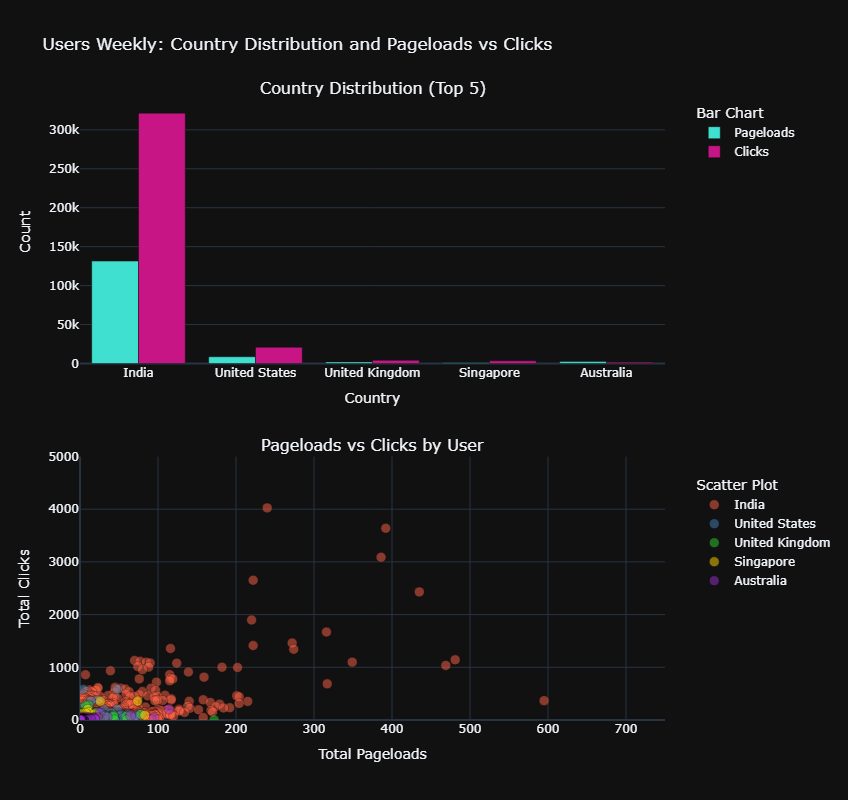

In [19]:
collection = db['users_weekly']

# function to fetch top N countries by total pageloads and clicks
def fetch_top_countries(collection, n):
    pipeline = [
        # filter documents with valid Country field
        {"$match": {"Country": {"$exists": True, "$ne": None}}},
        # convert pageloads and clicks to arrays
        {"$project": {"Country": 1, "pageloads": {"$objectToArray": "$pageloads"}, "clicks": {"$objectToArray": "$clicks"}}},
        # unwind pageloads and clicks arrays
        {"$unwind": "$pageloads"},
        {"$unwind": "$clicks"},
        # group by Country, summing pageloads and clicks
        {"$group": {"_id": "$Country", "total_count": {"$sum": {"$add": ["$pageloads.v", "$clicks.v"]}}}},
        # sort by total count in descending order
        {"$sort": {"total_count": -1}},
        # limit to top N countries
        {"$limit": n},
        # project to extract Country name
        {"$project": {"_id": 0, "Country": "$_id"}}
    ]
    return [doc['Country'] for doc in collection.aggregate(pipeline)]

# function to fetch bar plot data for specified countries
def fetch_bar_data(collection, countries):
    # pipeline to aggregate pageloads by country
    pipeline = [
        # filter documents with valid Country field and specified countries
        {"$match": {"Country": {"$exists": True, "$ne": None, "$in": countries}}},
        # convert pageloads object to array for unwinding
        {"$project": {"Country": 1, "pageloads": {"$objectToArray": "$pageloads"}}},
        # unwind pageloads array to process each entry
        {"$unwind": "$pageloads"},
        # group by Country, summing pageload values
        {"$group": {"_id": "$Country", "pageloads_count": {"$sum": "$pageloads.v"}}},
        # project to rename _id to Country and keep pageloads_count
        {"$project": {"_id": 0, "Country": "$_id", "pageloads_count": 1}}
    ]
    pageloads_data = list(collection.aggregate(pipeline))

    # pipeline to aggregate clicks by country
    pipeline = [
        # filter documents with valid Country field and specified countries
        {"$match": {"Country": {"$exists": True, "$ne": None, "$in": countries}}},
        # convert clicks object to array for unwinding
        {"$project": {"Country": 1, "clicks": {"$objectToArray": "$clicks"}}},
        # unwind clicks array to process each entry
        {"$unwind": "$clicks"},
        # group by Country, summing click values
        {"$group": {"_id": "$Country", "clicks_count": {"$sum": "$clicks.v"}}},
        # project to rename _id to Country and keep clicks_count
        {"$project": {"_id": 0, "Country": "$_id", "clicks_count": 1}}
    ]
    clicks_data = list(collection.aggregate(pipeline))

    # Ensure all specified countries are included, defaulting to 0 if no data
    pageloads_counts = [next((d['pageloads_count'] for d in pageloads_data if d['Country'] == c), 0) for c in countries]
    clicks_counts = [next((d['clicks_count'] for d in clicks_data if d['Country'] == c), 0) for c in countries]

    return countries, pageloads_counts, clicks_counts

# function to fetch scatter plot data for specified countries
def fetch_scatter_data(collection, countries):
    pipeline = [
        # filter documents for specified countries
        {"$match": {"Country": {"$exists": True, "$ne": None, "$in": countries}}},
        # group by userID and Country, summing pageloads and clicks
        {"$group": {
            "_id": {"userID": "$userID", "Country": "$Country"},
            "totalPageloads": {"$sum": {"$add": ["$pageloads.mobile", "$pageloads.desktop", "$pageloads.bot"]}},
            "totalClicks": {"$sum": {"$add": ["$clicks.mobile", "$clicks.desktop", "$clicks.bot"]}}
        }},
        # add totalActivity field for sorting
        {"$addFields": {"totalActivity": {"$add": ["$totalPageloads", "$totalClicks"]}}},
        # sort by total activity in descending order
        {"$sort": {"totalActivity": -1}},
        # project relevant fields
        {"$project": {"_id": 0, "userID": "$_id.userID", "Country": "$_id.Country", "totalPageloads": 1, "totalClicks": 1}}
    ]
    return list(collection.aggregate(pipeline))

# fetch top 5 countries
top_countries = fetch_top_countries(collection, 5)

# fetch bar plot data
bar_data = fetch_bar_data(collection, top_countries)

# fetch scatter plot data
scatter_data = fetch_scatter_data(collection, top_countries)

# prepare scatter plot data
countries_data = {country: {"pageloads": [], "clicks": [], "userIDs": []} for country in top_countries}
for doc in scatter_data:
    country = doc["Country"]
    countries_data[country]["pageloads"].append(doc["totalPageloads"])
    countries_data[country]["clicks"].append(doc["totalClicks"])
    countries_data[country]["userIDs"].append(doc["userID"])

# create subplot with 2 rows, 1 column
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Country Distribution (Top 5)', 'Pageloads vs Clicks by User'),
    vertical_spacing=0.15
)

# add bar plot traces
fig.add_trace(
    go.Bar(
        name='Pageloads',
        x=bar_data[0],
        y=bar_data[1],
        marker_color='#40E0D0',
        showlegend=True,
        legendgroup='bar',
        legend='legend1'
    ),
    row=1, col=1
)
fig.add_trace(
    go.Bar(
        name='Clicks',
        x=bar_data[0],
        y=bar_data[2],
        marker_color='#C71585',
        showlegend=True,
        legendgroup='bar',
        legend='legend1'
    ),
    row=1, col=1
)

# define color map for scatter plot
color_map = {
    top_countries[0]: "#FF6347",
    top_countries[1]: "#4682B4",
    top_countries[2]: "#32CD32",
    top_countries[3]: "#FFD700",
    top_countries[4]: "#9932CC"
}
# add scatter plot traces
for country in top_countries:
    if countries_data[country]["pageloads"]:
        fig.add_trace(
            go.Scatter(
                x=countries_data[country]["pageloads"],
                y=countries_data[country]["clicks"],
                mode='markers',
                name=country,
                marker=dict(size=10, color=color_map[country], opacity=0.5, line=dict(width=0.5, color='black')),
                text=countries_data[country]["userIDs"],
                hovertemplate="User: %{text}<br>Pageloads: %{x}<br>Clicks: %{y}<extra></extra>",
                showlegend=True,
                legendgroup='scatter',
                legend='legend2'
            ),
            row=2, col=1
        )

# update layout
fig.update_layout(
    barmode='group',
    title_text='Users Weekly: Country Distribution and Pageloads vs Clicks',
    template='plotly_dark',
    showlegend=True,
    legend1=dict(x=1.05, y=1.0, xanchor='left', yanchor='top', title='Bar Chart'),
    legend2=dict(x=1.05, y=0.2, xanchor='left', yanchor='bottom', title='Scatter Plot'),
    height=800
)

# update axes
fig.update_xaxes(title_text='Country', row=1, col=1)
fig.update_xaxes(title_text='Total Pageloads', range=[0, 750], row=2, col=1)
fig.update_yaxes(title_text='Count', row=1, col=1)
fig.update_yaxes(title_text='Total Clicks', range=[0, 5000], row=2, col=1)

# save and show plot
fig.write_html('top_5_country_pageloads_and_clicks.html')
fig.show()